<a href="https://colab.research.google.com/github/samantha96/Prejudice-Remover-Regularizer-Implementation/blob/main/Xuehan_PRLR_0321_onehot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as t
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd 
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

## 1.Data Preprocessing

In [ ]:
columns=['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income']
Train_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',header=None,names=columns)
Test_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',header=None,names=columns,skiprows=1)

In [ ]:
def process(dataset):
    df = dataset 
    df=df.replace(" ?",np.nan).dropna()#df.isnull().sum()
    df['income']=df['income'].map({' <=50K': 0, ' <=50K.': 0,' >50K': 1,' >50K.': 1})
    df['sex']=df['sex'].map({' Female': 1, ' Male': 0})
    return df
  

In [ ]:
def bin_var(data, var, bins, group_names):
    ds = data
    bin_value = bins
    group = group_names
    data[var] = pd.cut(ds[var], bin_value, labels=group)

In [ ]:
def workclas(x):
    if re.search('Private', x):
        return 'Private'
    elif re.search('Self', x):
        return 'selfempl'
    elif re.search('gov', x):
        return 'gov'
    else:
        return 'others'

In [ ]:
def relation(x):
  if re.search('Husband',x):
    return 'married'
  elif re.search('Wife', x):
    return 'married'
  else:
    return x

In [ ]:
def occup(x):
  if re.search('managerial', x):
    return 'Highskill'
  elif re.search('specialty',x):
    return 'Highskill'
  elif re.search('clerical',x):
    return 'Highskill'
  else:
    return 'Lowskill'

In [ ]:
def featureeng(df):
    bin_var(df, 'education_num', [0,6,11,16], ['Low', 'Medium', 'High'])
    bin_var(df, 'hours_per_week', [0,35,40,60,100], ['Low', 'Medium', 'High','VeryHigh'])
    bin_var(df, 'age', [17,30,55,100], ['Young', 'Middle_aged', 'Old'])
    df['workclass']=df.workclass.apply(lambda x: x.strip()).apply(lambda x: workclas(x))
    df['occupation']=df.occupation.apply(lambda x: x.strip()).apply(lambda x: occup(x))
    df['relationship']=df.relationship.apply(lambda x: x.strip()).apply(lambda x: relation(x))
    df.drop(['marital_status','education','fnlwgt','capital_gain','capital_loss','native_country'], axis=1, inplace=True)
    df = df.astype(str).apply(lambda col: LabelEncoder().fit_transform(col))
    return df


In [ ]:
def one_hot(data):
  x_data = data
  x_onehot =  F.one_hot(x_data[:,0])
  for i in range(1,x_data.shape[1]):
    x = F.one_hot(x_data[:,i])
    x_onehot = t.cat((x_onehot,x),1)
  return x_onehot

### Process training dataset

In [ ]:
df = process(Train_data) # y(target): income >50:1  <50:0
df = featureeng(df)

Only Female dataset for training

In [ ]:
#female
f = df.loc[df['sex']==1]
x_female = one_hot(t.from_numpy(np.array(f.drop(columns=['income','sex'])))).to(t.float32)
y_female = t.from_numpy(np.array(f['income']).astype('float32')).reshape(x_female.shape[0],1)
xy_female = t.cat((x_female,y_female),1)

Only male dataset for training

In [ ]:
#male
m = df.loc[df['sex']==0]
x_male = one_hot(t.from_numpy(np.array(m.drop(columns=['income','sex'])))).to(t.float32)
y_male = t.from_numpy(np.array(m['income']).astype('float32')).reshape(x_male.shape[0],1)
xy_male = t.cat((x_male,y_male),1)


### Process test dataset

In [ ]:
tf = process(Test_data) # y(target): income >50:1  <50:0
tf = featureeng(tf)

In [ ]:
x_test = one_hot(t.from_numpy(np.array(tf.drop(columns=['income','sex'])))).to(t.float32)
y_test = t.from_numpy(np.array(tf['income']).astype('float32')).reshape(x_test.shape[0],1)

In [ ]:
#female
f = df.loc[df['sex']==1]
xf_test = one_hot(t.from_numpy(np.array(f.drop(columns=['income','sex'])))).to(t.float32)
yf_test = t.from_numpy(np.array(f['income']).astype('float32')).reshape(xf_test.shape[0],1)


In [ ]:
#male
m = df.loc[df['sex']==0]
xm_test = one_hot(t.from_numpy(np.array(m.drop(columns=['income','sex'])))).to(t.float32)
ym_test = t.from_numpy(np.array(m['income']).astype('float32')).reshape(xm_test.shape[0],1)


In [ ]:
#Try linear
class LogisticRegression(nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        # out_features is the number of outputs. I don't use bias here because the constant dimension in x already introduced the bias term in W.
        self.w = nn.Linear(x_female.shape[1], out_features=1, bias=True)
        self.sigmod = nn.Sigmoid()
     def forward(self,x):
        # For the torch.nn.NLLLoss, the first input is the "log probability",log_softmax? log sigmod(binary).
        w = self.w(x)
        output = self.sigmod(w)
        return output

## 2.Define PRLR: 
### Object funtion: Loss function(negative log-likelihood) + Prejudice Remover Regularizer(mutual information) + l2 Regularizer

In [ ]:
class PRLoss():#using linear
     def __init__(self, eta=1.0):
        super(PRLoss, self).__init__()
        self.eta = eta
     def forward(self,output_f,output_m):
        # For the mutual information, 
        # Pr[y|s] = sum{(xi,si),si=s} sigma(xi,si) / #D[xs]
        #D[xs]
        N_female = t.tensor(output_f.shape[0])
        N_male   = t.tensor(output_m.shape[0])
        Dxisi = t.stack((N_male,N_female),axis=0) #male sample, #female sample
        # Pr[y|s]
        y_pred_female = t.sum(output_f)
        y_pred_male   = t.sum(output_m)
        P_ys = t.stack((y_pred_male,y_pred_female),axis=0) / Dxisi
        # Pr[y]
        P = t.cat((output_f,output_m),0)
        P_y = t.sum(P) / (x_female.shape[0]+x_male.shape[0])
        # P(siyi)
        P_s1y1 = t.log(P_ys[1]) - t.log(P_y)
        P_s1y0 = t.log(1-P_ys[1]) - t.log(1-P_y)
        P_s0y1 = t.log(P_ys[0]) - t.log(P_y)
        P_s0y0 = t.log(1-P_ys[0]) - t.log(1-P_y)
        # PI
        PI_s1y1 = output_f * P_s1y1
        PI_s1y0 =(1- output_f) * P_s1y0
        PI_s0y1 = output_m * P_s0y1
        PI_s0y0 = (1- output_m )* P_s0y0
        PI = t.sum(PI_s1y1) + t.sum(PI_s1y0) + t.sum(PI_s0y1) + t.sum(PI_s0y0)
        PI = self.eta * PI
        return PI

## 3.Model Validation

### Accuracy

In [ ]:
def accuracy( Model_f,Model_m, x_female, y_female,x_male,y_male):
    yf_pred = (Model_f(x_female) >= 0.5)
    ym_pred = (Model_m(x_male) >= 0.5)
    accu_f  = t.sum(yf_pred.flatten() == y_female.flatten()) / x_female.shape[0]
    accu_m  = t.sum(ym_pred.flatten() == y_male.flatten()) / x_male.shape[0]
    accuracy = (accu_f + accu_m) / 2
    return round(accuracy.item(),4)
    print("Accuracy : %.3f" % (accuracy * 100)+'%')

In [ ]:
 yf_pred = (Model_f(x_female) >= 0.5)
 ym_pred = (Model_m(x_male) >= 0.5)
 accu_f  = t.sum(yf_pred.flatten() == y_female.flatten()) / x_female.shape[0]
 accu_m  = t.sum(ym_pred.flatten() == y_male.flatten()) / x_male.shape[0]

In [ ]:
      model_f = LogisticRegression()
       model_m = LogisticRegression()
       criterion = nn.BCELoss(reduction='sum')
       PI = PRLoss(eta=self.eta)
       epochs = self.epochs
       optimizer = t.optim.Adam(list(model_f.parameters())+ list(model_m.parameters()), self.lr, weight_decay=1e-5)
       for epoch in range(epochs):
         optimizer.zero_grad()
         output_f = model_f(x_female)
         output_m = model_m(x_male)
         logloss = criterion(output_f, y_female)+ criterion(output_m, y_male)
         PIloss = PI.forward(output_f,output_m)
         loss = PIloss +logloss
         loss.backward()
         optimizer.step()

### CV_score

In [ ]:
# CVscore: Calder-Verwer discrimination score
# CV score on sample data: Pr[y=1 | S=0] - Pr[y=1 | S=1]
# For sample training data
# c=1: t.sum(y_data) 7508
# s=1: t.sum(s_data_onehot[:,0]) 9782
# s=0: t.sum(s_data_onehot[:,1]) 20380
pf = df[df['sex'] == 1]
high_f = pf[pf['income'] == 1]
pm = df[df['sex'] == 0]
high_m = pm[pm['income'] == 1]
# p[c=1 | s=1] 
p_c1s1 = high_f.shape[0]/pf.shape[0]
p_c1s0 = high_m.shape[0]/pm.shape[0]
p_cs = p_c1s0 - p_c1s1
print('training sample CV_score : %.4f' %( p_cs))

training sample CV_score : 0.2002


In [ ]:
def CVS(Model_f,Model_m,x_female,x_male):
    yf_pred = (Model_f(x_female) >= 0.5)
    ym_pred = (Model_m(x_male) >= 0.5)
    corr_f = t.sum(yf_pred == True)
    corr_m = t.sum(ym_pred == True)
    P_y1_s1 = corr_f / x_female.shape[0]
    P_y1_s0 = corr_m / x_male.shape[0]
    CV_score = t.abs(P_y1_s0 - P_y1_s1)
    return round(CV_score.item(),4)
    print ('Calder-Verwer discrimination score: %.4f' % (CV_score.item()))
    

## 4.Model implementation: Logistic regression model with PR Regularizer

In [ ]:
class PRLR():#using linear
     def __init__(self, eta=0.0,epochs = 3000,lr = 0.01):
        super(PRLR, self).__init__()
        self.eta = eta
        self.epochs = epochs
        self.lr = lr
     def fit(self,x_female,y_female,x_male,y_male):
       model_f = LogisticRegression()
       model_m = LogisticRegression()
       criterion = nn.BCELoss(reduction='sum')
       PI = PRLoss(eta=self.eta)
       epochs = self.epochs
       optimizer = t.optim.Adam(list(model_f.parameters())+ list(model_m.parameters()), self.lr, weight_decay=1e-5)
       for epoch in range(epochs):
         optimizer.zero_grad()
         output_f = model_f(x_female)
         output_m = model_m(x_male)
         logloss = criterion(output_f, y_female)+ criterion(output_m, y_male)
         PIloss = PI.forward(output_f,output_m)
         loss = PIloss +logloss
         loss.backward()
         optimizer.step()
       model_f.eval()
       model_m.eval()
       accu = accuracy(model_f,model_m,x_female,y_female,x_male,y_male)
       cvs = CVS(model_f,model_m,x_female, x_male)
       return accu,cvs

## 5.change eta and observe the change of accuracy and CV-score

In [ ]:
PR = PRLR(eta = 1.0, epochs = 3000, lr = 0.01)

In [ ]:
t.tensor(PR.fit(x_female,y_female,x_male,y_male)).reshape(2,1)

tensor([[0.8444],
        [0.1125]])

## 6.Results Plot

In [ ]:
eta_value = [0.0,1.0,2.0,3.0,4.0,5.0,10.0,15.0,20.0,25.0,30.0,80.0]
PR = PRLR(eta = 0.0, epochs = 3000, lr = 0.01)
accv = t.tensor(PR.fit(x_female,y_female,x_male,y_male)).reshape(2,1)

In [ ]:
for e in range(1,len(eta_value)):
  PR = PRLR(eta = eta_value[e], epochs = 3000, lr = 0.01)
  accv2 = t.tensor(PR.fit(x_female,y_female,x_male,y_male)).reshape(2,1)
  accv = t.cat((accv,accv2),1)

In [ ]:
accv

tensor([[0.8457, 0.8444, 0.8406, 0.8404, 0.8368, 0.8362, 0.8349, 0.8347, 0.8313,
         0.8311, 0.8309, 0.8306],
        [0.1679, 0.1125, 0.0725, 0.0708, 0.0567, 0.0527, 0.0340, 0.0311, 0.0192,
         0.0138, 0.0118, 0.0074]])

In [ ]:
eta_accu = accv[0].tolist()
eta_cvs = accv[1].tolist()

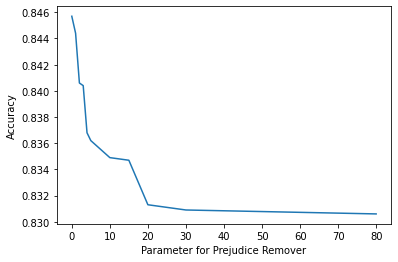

In [ ]:
plt.plot(eta_value,eta_accu)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('Accuracy')
plt.show()

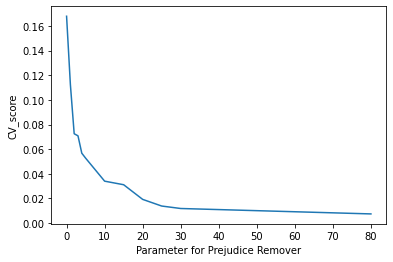

In [ ]:
plt.plot(eta_value,eta_cvs)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('CV_score')
plt.show()